<a id='home'></a>
### Contents

[Imports](#Imports)

[Data loading and processing](#Dataloadingandprocessing)

[BigARTM LDA](#BigARTMLDA)

[BigARTM ARTM model](#BigARTMARTMmodel)

<a id='Imports'></a>
### Imports
[back to contents](#home)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q spacy==3.4.3
!pip install -q gensim==4.2.0
!pip install -q pymorphy2==0.9.1
!pip install -q bigartm10
!pip install -q wordcloud==1.8.2.2

     |██████▋                         | 5.0 MB 7.3 MB/s eta 0:00:03

     |████████████▎                   | 9.3 MB 7.3 MB/s eta 0:00:03

     |█████████████████▎              | 13.0 MB 7.3 MB/s eta 0:00:02

     |████████████████████████        | 18.0 MB 7.3 MB/s eta 0:00:01

     |████████████████████████████▏   | 21.2 MB 1.7 MB/s eta 0:00:02

     |████████████████████████████████| 24.1 MB 1.7 MB/s eta 0:00:01

     |████████████████████████████████| 24.1 MB 1.7 MB/s 
     |████████████████████████████████| 55 kB 2.8 MB/s eta 0:00:011
     |████████████████████████████████| 8.2 MB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 7.4 MB/s eta 0:00:01


In [3]:
import os
import sys
sys.path.insert(0, '/content/drive/MyDrive/python_scripts/')
import re
import time
import itertools
from tqdm.notebook import tqdm
import pickle
import json
import joblib
import collections

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [ ]:
# # Подключение данных гугл диска
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import spacy
import gensim
import artm

---

<a id='Dataloadingandprocessing'></a>
### Data loading and processing
[back to contents](#home)

In [6]:
from sklearn.datasets import fetch_20newsgroups

news_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = news_data['data']
targets = news_data['target'].astype(int)

target2id_dict = {name: i for i, name in enumerate(news_data['target_names'])}
id2target_dict = {x: y for y, x in target2id_dict.items()}

In [8]:
# np.random.seed(42)
random_idx = np.random.choice(len(texts))
print(f"idx: {random_idx}", end='\n\n')
print(f'text:')
print(texts[random_idx], end='\n\n')
print(f"target: {id2target_dict[targets[random_idx]]}", end='\n\n')

idx: 860

text:
Could someone post the Flyers record with and without Eric Lindros in
the lineup


I have a guy that is trying to compare the Quebec/Flyers trade to the 

Dallas/Minnesota trade in the NFL(Hershel Walker)

I just need the stat to back up my point that Eric will be one of the next

great players

thanks

target: rec.sport.hockey



In [73]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

processed_texts = []

for text in tqdm(texts, total=len(texts)):
    sentence = ' '.join(gensim.utils.simple_preprocess(text, deacc=True))
    doc = nlp(sentence)
    current_lemmatized_text = []
    for token in doc:
        if not any([token.is_punct, token.is_bracket, token.is_stop, token.is_space]):
            current_lemmatized_text.append(token.lemma_.lower())
    processed_texts.append(current_lemmatized_text)

  0%|          | 0/18846 [00:00<?, ?it/s]

In [74]:
import json

json.dump(
    processed_texts,
    open('/content/drive/MyDrive/Data/20newsgroups/processed_texts.json', mode='w', encoding='utf-8'),
    ensure_ascii=False,
    indent=2
)

In [10]:
processed_texts = json.load(
    open('/content/drive/MyDrive/Data/20newsgroups/processed_texts.json', mode='r', encoding='utf-8')
)
print(f"processed_texts: {len(processed_texts):,}")
print("text example:", processed_texts[0])

processed_texts: 18,846
text example: ['sure', 'basher', 'pen', 'fan', 'pretty', 'confused', 'lack', 'kind', 'post', 'recent', 'pen', 'massacre', 'devil', 'actually', 'bit', 'puzzle', 'bit', 'relieved', 'go', 'end', 'non', 'pittsburgher', 'relief', 'bit', 'praise', 'pen', 'man', 'kill', 'devil', 'bad', 'think', 'jagr', 'show', 'well', 'regular', 'season', 'stat', 'lot', 'fo', 'fun', 'watch', 'playoff', 'bowman', 'let', 'jagr', 'lot', 'fun', 'couple', 'game', 'pen', 'go', 'beat', 'pulp', 'jersey', 'disappointed', 'islander', 'lose', 'final', 'regular', 'season', 'game', 'pen', 'rule']


<a id='GensimLDA'></a>
### Gensim LDA
[back to contents](#home)

In [11]:
from gensim import corpora

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(processed_texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_texts]

In [ ]:
phi = 100_000 x 15 = p(w|t)
theta = 15 x 18_000 = p(t|d)

In [16]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

CPU times: user 3min 42s, sys: 50.8 s, total: 4min 33s
Wall time: 3min 41s


In [17]:
lda_model.show_topics(formatted=False, num_topics=15)

[(0,
  [('ax', 0.10253253),
   ('patient', 0.026007246),
   ('fbi', 0.025366982),
   ('md', 0.020397477),
   ('haven', 0.020094415),
   ('wasn', 0.019852573),
   ('mm', 0.01866978),
   ('ma', 0.014669034),
   ('max', 0.013804455),
   ('effective', 0.0134697845)]),
 (1,
  [('know', 0.022500195),
   ('like', 0.021634286),
   ('don', 0.018670777),
   ('good', 0.017163202),
   ('think', 0.016959071),
   ('time', 0.014759931),
   ('go', 0.012031523),
   ('want', 0.011779649),
   ('look', 0.010958441),
   ('work', 0.0108580915)]),
 (2,
  [('edu', 0.1083668),
   ('file', 0.09321023),
   ('com', 0.073111504),
   ('display', 0.036357015),
   ('graphic', 0.029960413),
   ('pub', 0.024534268),
   ('gov', 0.021703243),
   ('directory', 0.016527489),
   ('cs', 0.01650336),
   ('share', 0.015605943)]),
 (3,
  [('subject', 0.11437872),
   ('safety', 0.06434516),
   ('universe', 0.04211349),
   ('strip', 0.021774147),
   ('sunday', 0.021445805),
   ('damn', 0.01824271),
   ('taxis', 0.017564531),
   (

0it [00:00, ?it/s]

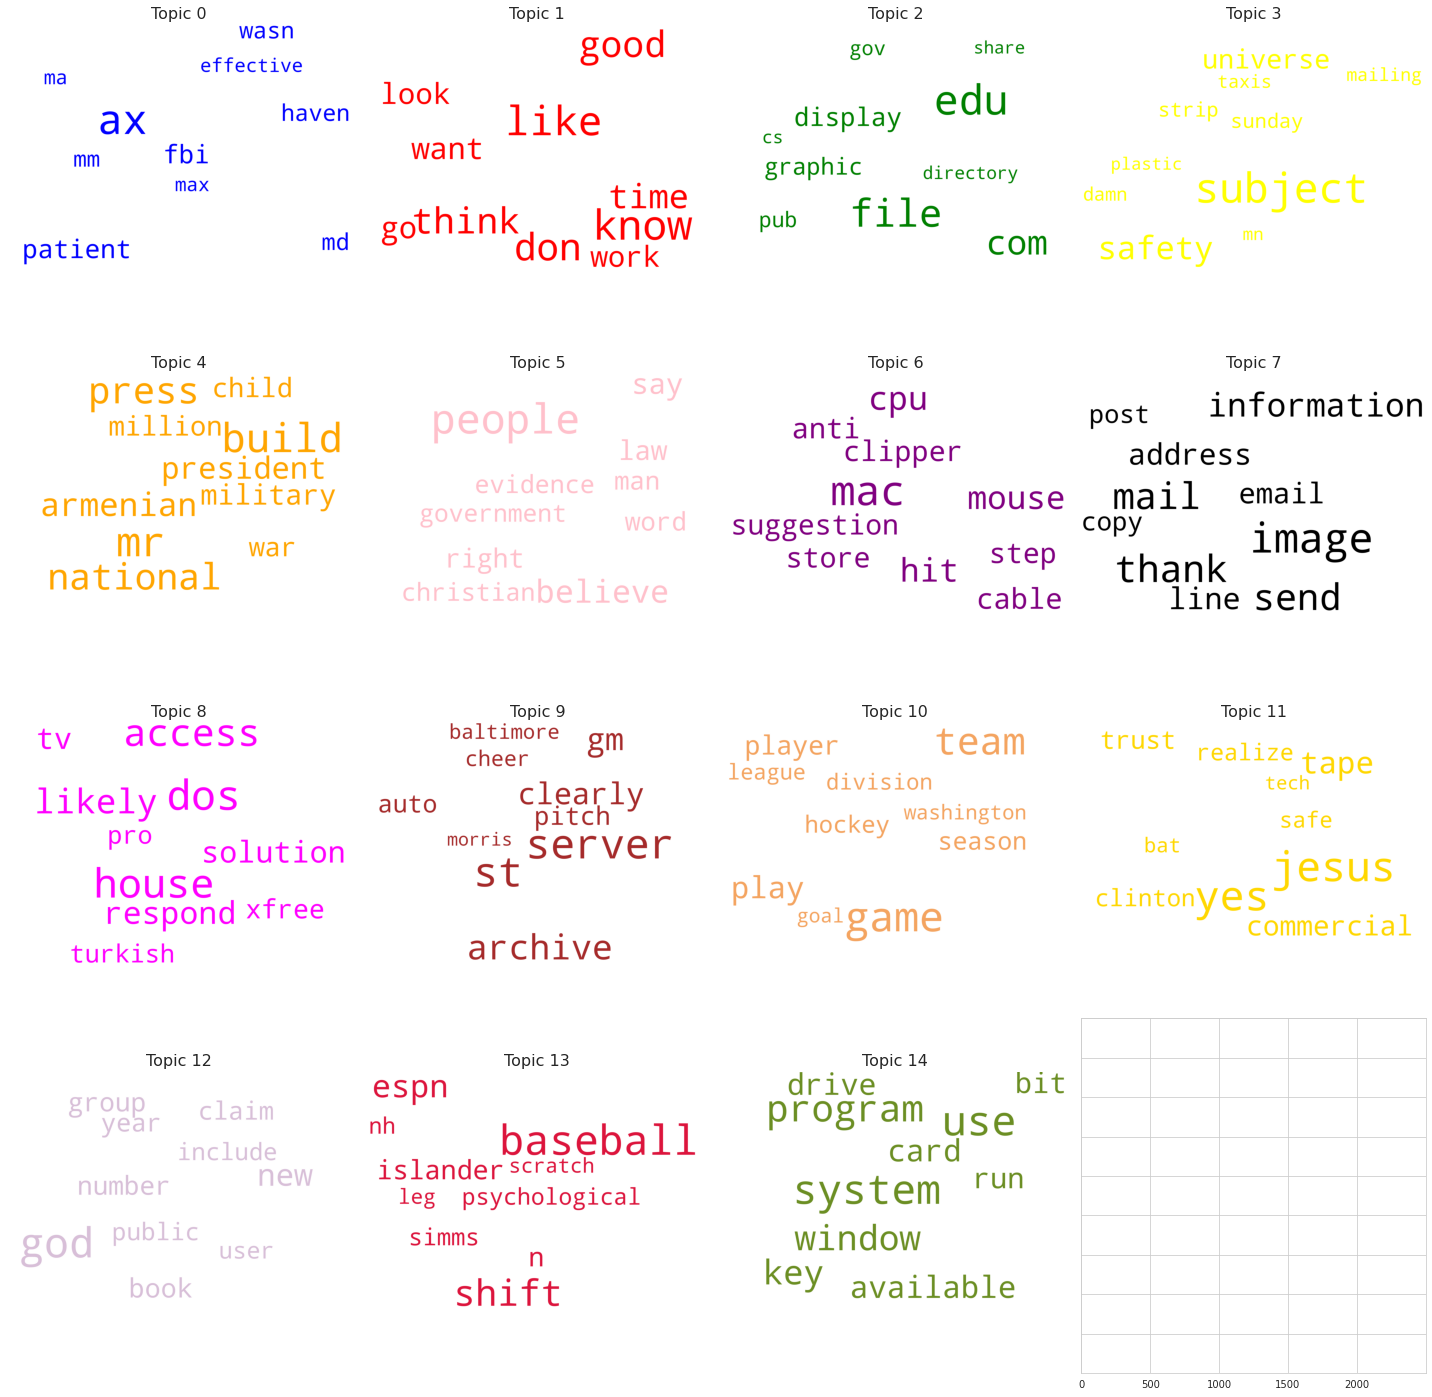

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

colors = ['blue', 'red', 'green', 'yellow', 'orange', 'pink', 'purple', 'black', 'magenta', 'brown']
np.random.seed(42)
cols = list(np.random.permutation(list(matplotlib.colors.cnames.keys())))
colors = colors + [color for color in cols if color not in colors]

cloud = WordCloud(stopwords=None,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i],
                  prefer_horizontal=1.0)

topics = topics = lda_model.show_topics(formatted=False, num_topics=15)

ncols = 4
nrows = len(topics) // ncols if len(topics) % ncols == 0 else len(topics) // ncols + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20), sharex=True, sharey=True)

for i, ax in tqdm(enumerate(axes.flatten())):
    if i == len(topics):
        break
    fig.add_subplot(ax)
    topic_words = {k: v*10 for k, v in dict(topics[i][1]).items()}
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout(h_pad=3)
plt.show()

<a id='BigARTMLDA'></a>
### BigARTM LDA
[back to contents](#home)

In [11]:
# /content/drive/MyDrive/python_scripts/
from bigartm_utils import texts_to_vw_format

texts_to_vw_format(
    processed_texts=[text_list for text_list in processed_texts if len(text_list) > 0],
    dataset_name='20newsgroups',
    save_files_folder='/content/drive/MyDrive/Data/20newsgroups/'
)

18290it [00:00, 41140.14it/s]


In [9]:
# # /content/drive/MyDrive/python_scripts/
# from bigartm_utils import texts_to_uci_format

# texts_to_uci_format(
#     processed_texts=[text_list for text_list in processed_texts if len(text_list) > 0],
#     dataset_name='20newsgroups',
#     save_files_folder='/content/drive/MyDrive/Data/20newsgroups/'
# )

In [24]:
bv = artm.BatchVectorizer(
    data_path='/content/drive/MyDrive/Data/20newsgroups/vw.20newsgroups.txt', 
#     data_format='bow_uci',
    data_format='vowpal_wabbit',
#     collection_name='20newsgroups', 
    target_folder='20newsgroups_batches'
)

In [27]:
lda = artm.LDA(
    num_topics=15, 
    alpha=0.01, 
    beta=0.001, 
    cache_theta=True,
    num_document_passes=5, 
    dictionary=bv.dictionary
)

In [28]:
%%time
for i in tqdm(range(10)):
    lda.fit_offline(batch_vectorizer=bv, num_collection_passes=1)
    print(f"Iter: {i}\tperplexity: {round(lda.perplexity_value[-1], 2)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Iter: 0	perplexity: 81145.03
Iter: 1	perplexity: 5013.39
Iter: 2	perplexity: 4060.08
Iter: 3	perplexity: 3128.55
Iter: 4	perplexity: 2667.07
Iter: 5	perplexity: 2458.53
Iter: 6	perplexity: 2338.2
Iter: 7	perplexity: 2259.02
Iter: 8	perplexity: 2204.84
Iter: 9	perplexity: 2166.94
CPU times: user 44.1 s, sys: 756 ms, total: 44.8 s
Wall time: 28.8 s


In [29]:
top_tokens = lda.get_top_tokens(num_tokens=10, with_weights=False)
for i, token_list in enumerate(top_tokens):
     print(f'Topic #{i}: {token_list}')

Topic #0: ['window', 'file', 'use', 'run', 'program', 'problem', 'work', 'system', 'scsi', 'do']
Topic #1: ['like', 'don', 'key', 'time', 'chip', 'people', 'think', 'want', 'good', 'right']
Topic #2: ['game', 'car', 'play', 'team', 'go', 'think', 'don', 'mr', 'know', 'time']
Topic #3: ['people', 'gun', 'government', 'state', 'right', 'israel', 'country', 'law', 'think', 'year']
Topic #4: ['god', 'people', 'believe', 'know', 'christian', 'think', 'don', 'mean', 'bible', 'point']
Topic #5: ['software', 'thank', 'card', 'pc', 'available', 'edu', 'include', 'monitor', 'com', 'support']
Topic #6: ['space', 'year', 'patient', 'disease', 'medical', 'earth', 'orbit', 'mission', 'la', 'pt']
Topic #7: ['ax', 'max', 'pl', 'tm', 'di', 'ei', 'wm', 'giz', 'bhj', 'ey']
Topic #8: ['db', 'hz', 'cx', 'ww', 'pl', 'c', 'uw', 'ah', 'mw', 'mc']
Topic #9: ['drive', 'like', 'use', 'know', 'problem', 'disk', 'good', 'don', 'work', 'need']
Topic #10: ['think', 'know', 'year', 'good', 'say', 'like', 'get', 'don'

In [19]:
lda.phi_.shape, lda.get_theta().shape

((83990, 15), (15, 18290))

0it [00:00, ?it/s]

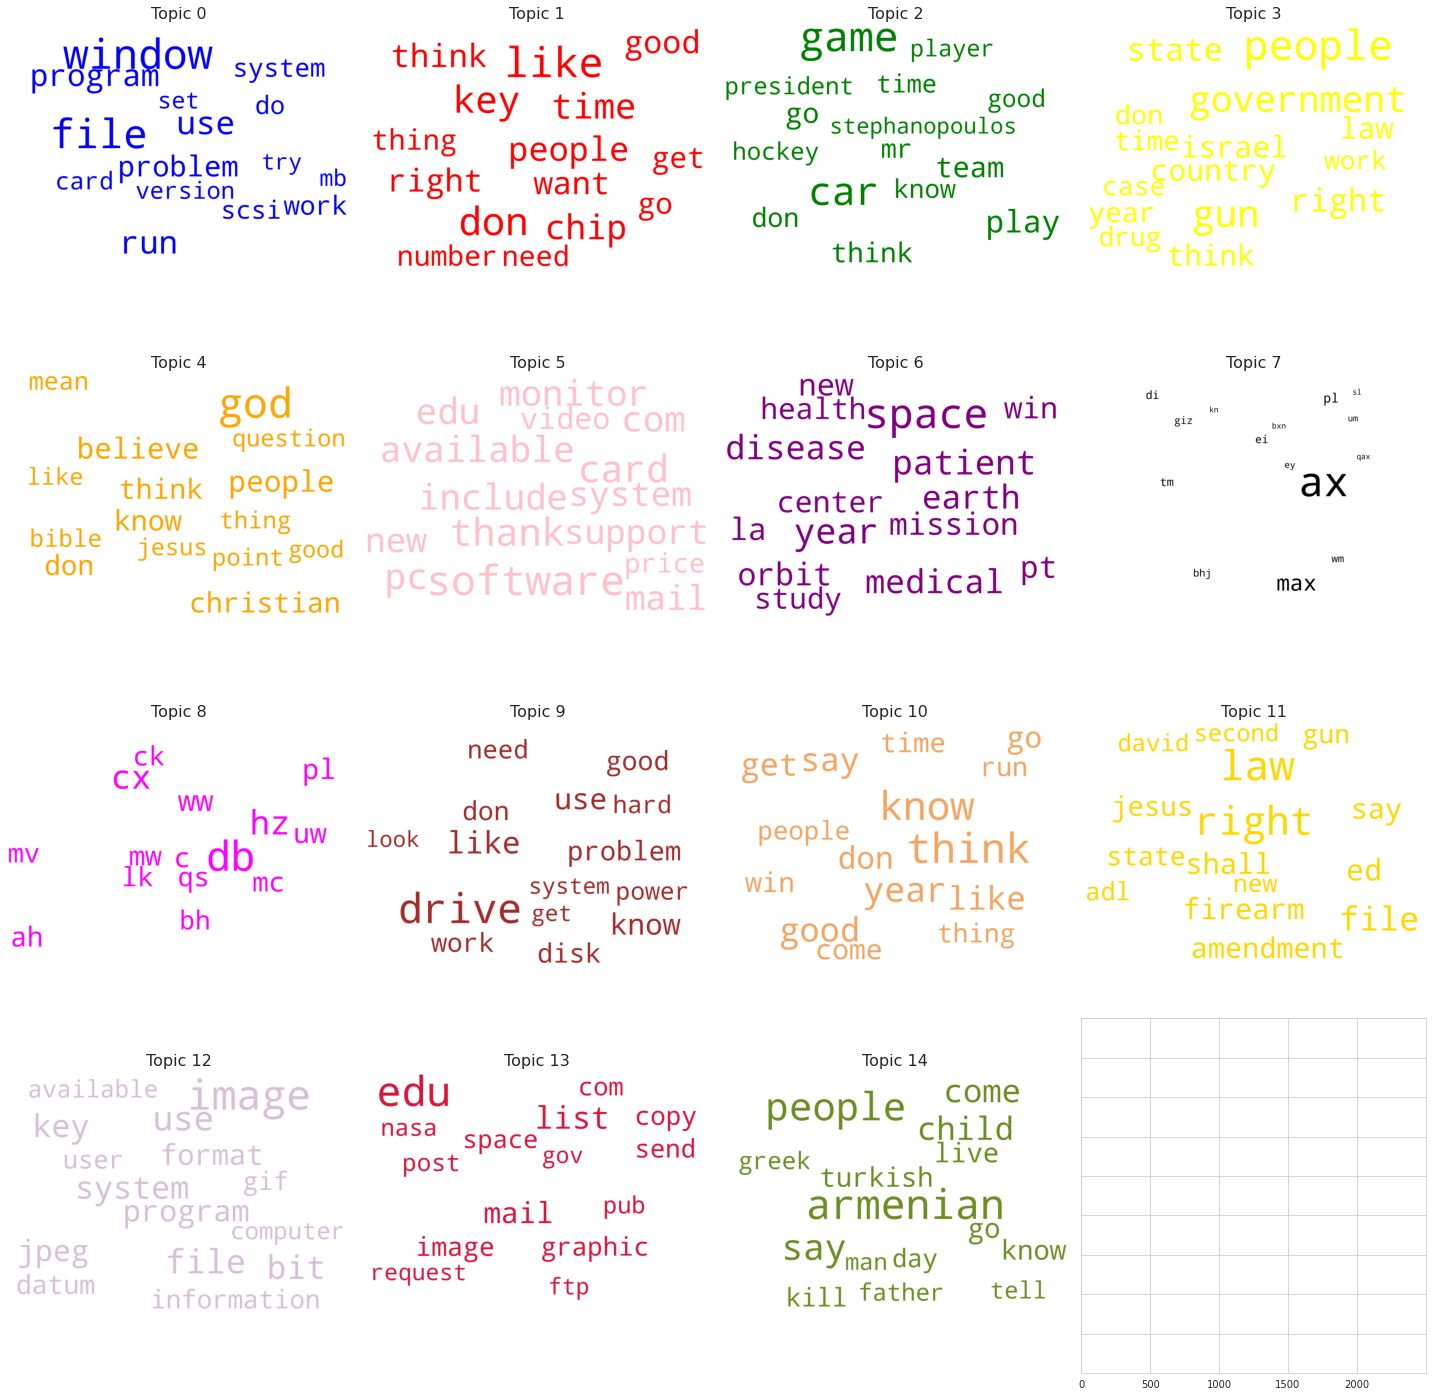

In [30]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

colors = ['blue', 'red', 'green', 'yellow', 'orange', 'pink', 'purple', 'black', 'magenta', 'brown']
np.random.seed(42)
cols = list(np.random.permutation(list(matplotlib.colors.cnames.keys())))
colors = colors + [color for color in cols if color not in colors]

cloud = WordCloud(stopwords=None,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i],
                  prefer_horizontal=1.0)

# topics = lda_model.show_topics(formatted=False, num_topics=10)
topics = [
    (topic_id, tokens_list) for topic_id, tokens_list in 
    enumerate(lda.get_top_tokens(num_tokens=15, with_weights=True))
]

ncols = 4
nrows = len(topics) // ncols if len(topics) % ncols == 0 else len(topics) // ncols + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20), sharex=True, sharey=True)

for i, ax in tqdm(enumerate(axes.flatten())):
    if i == len(topics):
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout(h_pad=3)
plt.show()

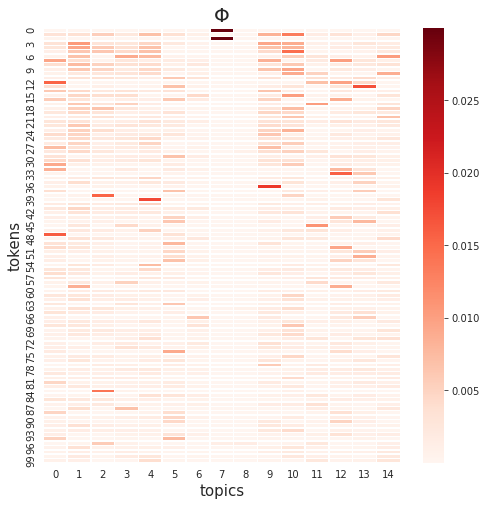

In [88]:
plt.title(r'$\Phi$', fontsize=20)
sns.heatmap(
    lda.phi_.values[lda.phi_.sum(axis=1).values.argsort()[::-1][:100]].clip(max=0.03),
    cmap='Reds',
    lw=0.5
);
plt.ylabel('tokens', fontsize=15)
plt.xlabel('topics', fontsize=15);

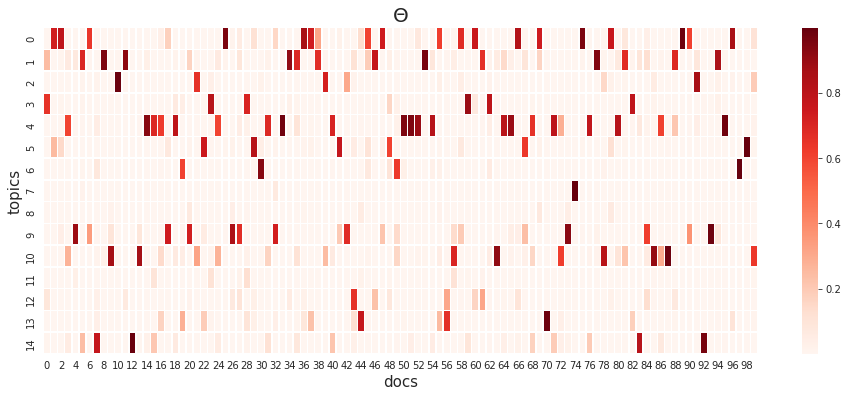

In [87]:
truncated_theta = lda.get_theta().values[:, (lda.get_theta().max(axis=0) > 0.6).values]
truncated_theta = truncated_theta[:, np.random.choice(truncated_theta.shape[1], size=100)]

plt.figure(figsize=(16, 6))
plt.title(r'$\Theta$', fontsize=20)
sns.heatmap(
    truncated_theta,
    cmap='Reds',
    lw=0.5
);
plt.ylabel('topics', fontsize=15)
plt.xlabel('docs', fontsize=15);

<a id='BigARTMARTMmodel'></a>
### BigARTM ARTM model
[back to contents](#home)

In [31]:
bv = artm.BatchVectorizer(
    data_path='/content/drive/MyDrive/Data/20newsgroups/vw.20newsgroups.txt', 
    data_format='vowpal_wabbit',
    target_folder='20newsgroups_batches',
    gather_dictionary=True,
)

In [65]:
model = artm.ARTM(
    num_topics=15,  
    num_document_passes=10,
    cache_theta=True,
    seed=42, 
    show_progress_bars=False, 
    dictionary=bv.dictionary
)

In [66]:
model.scores.add(
    artm.PerplexityScore(name='perp', dictionary=bv.dictionary),
)
model.scores.add(
    artm.TopTokensScore(name='top_tok', num_tokens=10)
)
model.scores.add(
    artm.SparsityPhiScore(name='sparce_phi')
)

In [67]:
model.scores

[perp, top_tok, sparce_phi]

  0%|          | 0/20 [00:00<?, ?it/s]

Iter: 0  perp. value: 3592.523  sparcity: 0.067
Iter: 1  perp. value: 2881.058  sparcity: 0.207
Iter: 2  perp. value: 2528.472  sparcity: 0.316
Iter: 3  perp. value: 2356.684  sparcity: 0.429
Iter: 4  perp. value: 2262.132  sparcity: 0.526
Iter: 5  perp. value: 2201.615  sparcity: 0.588
Iter: 6  perp. value: 2160.274  sparcity: 0.635
Iter: 7  perp. value: 2131.475  sparcity: 0.671
Iter: 8  perp. value: 2110.616  sparcity: 0.697
Iter: 9  perp. value: 2094.496  sparcity: 0.719
Iter: 10  perp. value: 2081.23  sparcity: 0.737
Iter: 11  perp. value: 2070.14  sparcity: 0.751
Iter: 12  perp. value: 2060.826  sparcity: 0.764
Iter: 13  perp. value: 2052.645  sparcity: 0.774
Iter: 14  perp. value: 2044.313  sparcity: 0.782
Iter: 15  perp. value: 2037.372  sparcity: 0.79
Iter: 16  perp. value: 2032.313  sparcity: 0.797
Iter: 17  perp. value: 2027.698  sparcity: 0.803
Iter: 18  perp. value: 2023.343  sparcity: 0.809
Iter: 19  perp. value: 2019.304  sparcity: 0.813


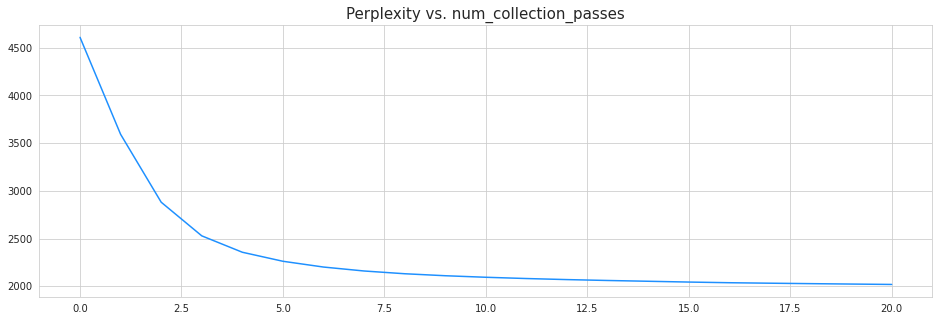

In [70]:
num_collection_passes = 20
for _ in tqdm(range(num_collection_passes)):
    model.fit_offline(batch_vectorizer=bv, num_collection_passes=1)
    perp = model.score_tracker['perp'].last_value
    sparcity = model.score_tracker['sparce_phi'].last_value
    print(f"Iter: {_}  perp. value: {round(perp, 3)}  sparcity: {round(sparcity, 3)}")

plt.figure(figsize=(16, 5))
plt.title(f'Perplexity vs. num_collection_passes', fontsize=15)
plt.plot(model.score_tracker['perp'].value[1:], color='dodgerblue');

In [71]:
from pprint import pprint

In [72]:
pprint(model.score_tracker['top_tok'].last_tokens)

{'topic_0': ['hz', 'cx', 'ww', 'uw', 'pl', 'c', 'ck', 'lk', 'ah', 'qs'],
 'topic_1': ['game',
             'year',
             'team',
             'gun',
             'play',
             'win',
             'good',
             'player',
             'think',
             'season'],
 'topic_10': ['ms', 'db', 'bh', 'mk', 'mp', 'm', 'ma', 'mm', 'mo', 'mj'],
 'topic_11': ['armenian',
              'president',
              'mr',
              'turkish',
              'war',
              'muslim',
              'government',
              'stephanopoulos',
              'turkey',
              'pt'],
 'topic_12': ['edu',
              'com',
              'mail',
              'post',
              'thank',
              'send',
              'list',
              'article',
              'email',
              'address'],
 'topic_13': ['god',
              'people',
              'believe',
              'know',
              'think',
              'jesus',
              'say',
     

In [73]:
model.regularizers.add(
    artm.DecorrelatorPhiRegularizer(name='decor', tau=1e+5)
)

  0%|          | 0/20 [00:00<?, ?it/s]

Iter: 0  perp. value: 2015.312  sparcity: 0.818
Iter: 1  perp. value: 2011.407  sparcity: 0.821
Iter: 2  perp. value: 2007.836  sparcity: 0.825
Iter: 3  perp. value: 2004.485  sparcity: 0.828
Iter: 4  perp. value: 2001.662  sparcity: 0.831
Iter: 5  perp. value: 1999.189  sparcity: 0.833
Iter: 6  perp. value: 1996.918  sparcity: 0.836
Iter: 7  perp. value: 1994.725  sparcity: 0.838
Iter: 8  perp. value: 1992.616  sparcity: 0.84
Iter: 9  perp. value: 1990.657  sparcity: 0.842
Iter: 10  perp. value: 1988.769  sparcity: 0.843
Iter: 11  perp. value: 1986.938  sparcity: 0.845
Iter: 12  perp. value: 1985.348  sparcity: 0.846
Iter: 13  perp. value: 1983.918  sparcity: 0.848
Iter: 14  perp. value: 1982.52  sparcity: 0.849
Iter: 15  perp. value: 1981.12  sparcity: 0.85
Iter: 16  perp. value: 1979.686  sparcity: 0.852
Iter: 17  perp. value: 1978.281  sparcity: 0.853
Iter: 18  perp. value: 1976.92  sparcity: 0.854
Iter: 19  perp. value: 1975.597  sparcity: 0.855


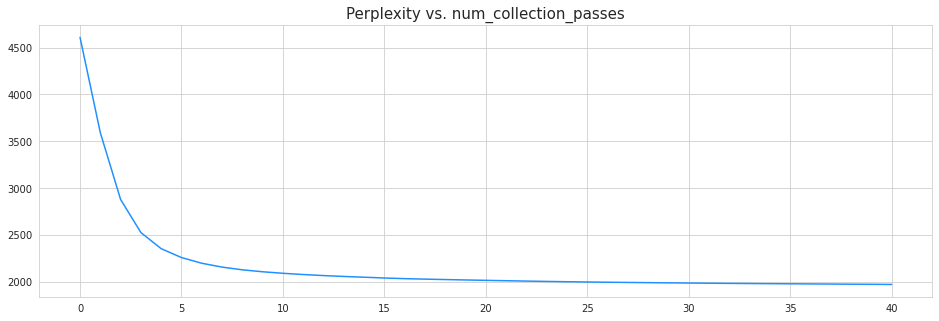

In [74]:
num_collection_passes = 20
for _ in tqdm(range(num_collection_passes)):
    model.fit_offline(batch_vectorizer=bv, num_collection_passes=1)
    perp = model.score_tracker['perp'].last_value
    sparcity = model.score_tracker['sparce_phi'].last_value
    print(f"Iter: {_}  perp. value: {round(perp, 3)}  sparcity: {round(sparcity, 3)}")

plt.figure(figsize=(16, 5))
plt.title(f'Perplexity vs. num_collection_passes', fontsize=15)
plt.plot(model.score_tracker['perp'].value[1:], color='dodgerblue');

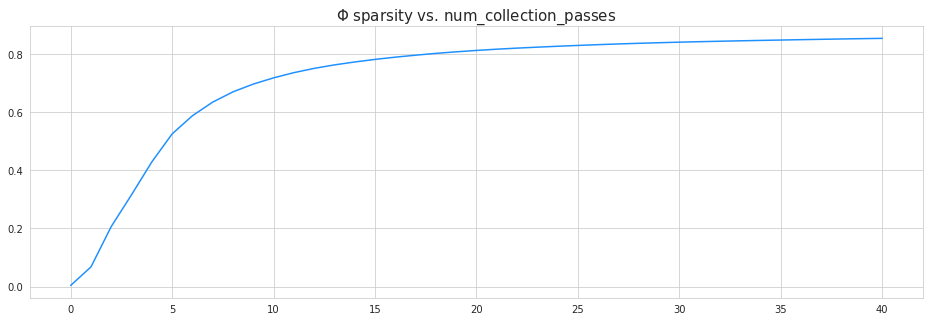

In [76]:
plt.figure(figsize=(16, 5))
plt.title(rf'$\Phi$ sparsity vs. num_collection_passes', fontsize=15)
plt.plot(model.score_tracker['sparce_phi'].value[1:], color='dodgerblue');

0it [00:00, ?it/s]

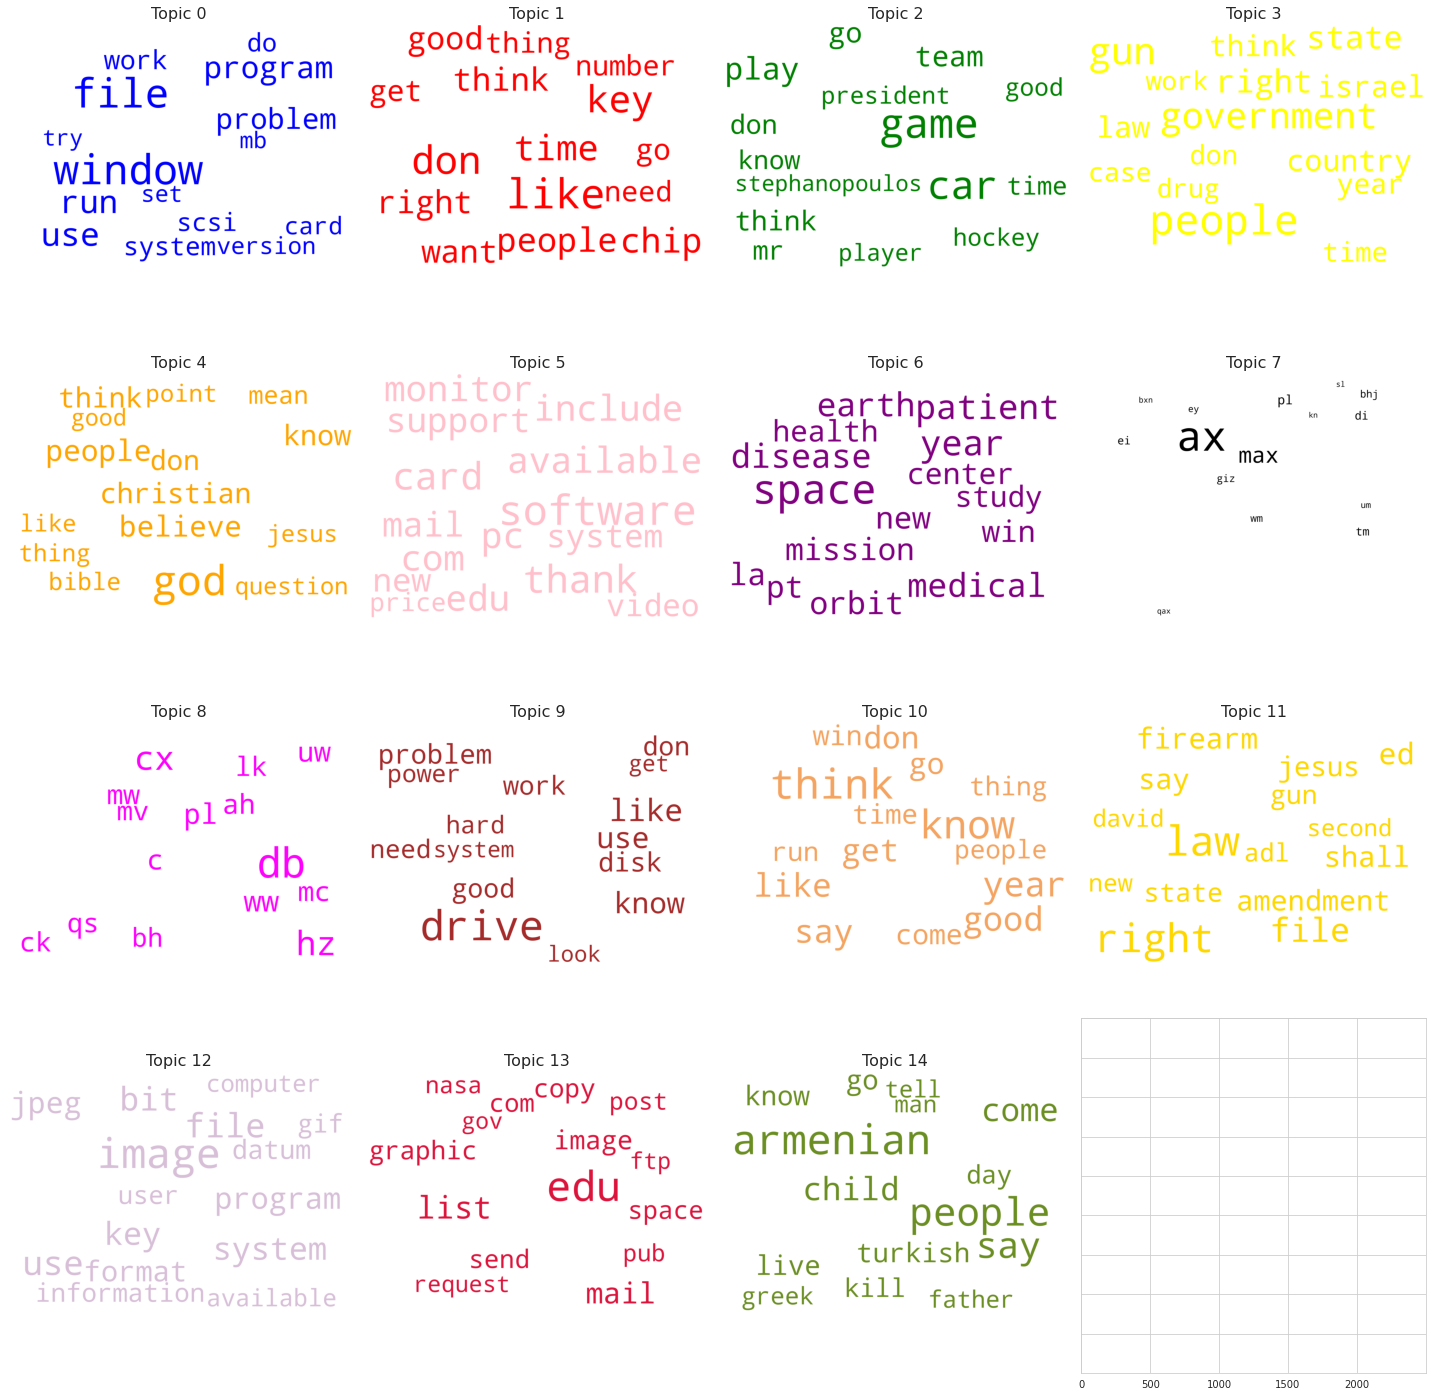

In [77]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

colors = ['blue', 'red', 'green', 'yellow', 'orange', 'pink', 'purple', 'black', 'magenta', 'brown']
np.random.seed(42)
cols = list(np.random.permutation(list(matplotlib.colors.cnames.keys())))
colors = colors + [color for color in cols if color not in colors]

cloud = WordCloud(stopwords=None,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i],
                  prefer_horizontal=1.0)

# topics = lda_model.show_topics(formatted=False, num_topics=10)
topics = [
    (topic_id, tokens_list) for topic_id, tokens_list in 
    enumerate(lda.get_top_tokens(num_tokens=15, with_weights=True))
]

ncols = 4
nrows = len(topics) // ncols if len(topics) % ncols == 0 else len(topics) // ncols + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20), sharex=True, sharey=True)

for i, ax in tqdm(enumerate(axes.flatten())):
    if i == len(topics):
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout(h_pad=3)
plt.show()